In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

# use GPU for computation if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# load code for NVAE

# make sure that files in local directory can be imported
import sys
sys.path.insert(0, ".")

# try to import nvae module and download it if it fails
import urllib
try:
    import nvae
except ImportError:
    urllib.request.urlretrieve("https://uu-sml.github.io/course-apml-public/lab/nvae.py", "nvae.py")
    import nvae

# Deep hierarchical variational autoencoder

We studied PCA, probabilistic PCA, and a simple variational autoencoder (VAE) on the MNIST data of handwritten digits in exercise 8.1 and the computer lab (links to the material can be found [here](https://uu-sml.github.io/course-apml-public/)). In this notebook we will play around with a much more complicated VAE, the so-called [nouveau variational autoencoder (NVAE)](https://arxiv.org/abs/2007.03898). It is based on an advanced deep hierarchical structure of the encoder and decoder. The authors applied it to multiple image data sets such as the MNIST data set and the [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) and [CelebA HQ](https://research.nvidia.com/sites/default/files/pubs/2017-10_Progressive-Growing-of/karras2018iclr-paper.pdf) data sets of celebrity images. The image below shows samples of the NVAE for the CelebA HQ data set.

<img src="https://raw.githubusercontent.com/NVlabs/NVAE/master/img/celebahq.png" width="800">

## Before you start

It is strongly recommended that you complete the first parts of the computer lab and perform a probabilistic PCA and train a simple VAE on the MNIST data before running this notebook. You can download the notebook for the PPCA model [here](https://uu-sml.github.io/course-apml-public/lab/PPCA.ipynb) and run it on your computer, or you can [open it on Google Colab](https://colab.research.google.com/github/uu-sml/course-apml-public/blob/master/lab/PPCA.ipynb). The notebook for the VAE you can download [here](https://uu-sml.github.io/course-apml-public/lab/VAE.ipynb) or you can [open it on Google Colab](https://colab.research.google.com/github/uu-sml/course-apml-public/blob/master/lab/VAE.ipynb)

We recommend also that you [open this notebook on Google Colab](https://colab.research.google.com/github/uu-sml/course-apml-public/blob/master/lab/NVAE.ipynb) since it allows you to use GPUs which will speed up the computations a lot (you can enable GPU support in the "Runtime" -> "Change runtime type" menu). Alternatively, you can run the notebook on your computer. In this notebook we use [PyTorch](https://pytorch.org/), an open source software library for machine learning. Make sure that you have installed the latest version of PyTorch if you run the notebook on your computer. 

A Jupyter notebook with an introduction to PyTorch can be downloaded from [here](https://uu-sml.github.io/course-sml-public/lab/introduction.ipynb). Alternatively, you can [open it on Google Colab](https://colab.research.google.com/github/uu-sml/course-sml-public/blob/master/lab/introduction.ipynb). Reading and running the notebook is highly recommended, since it introduces important concepts and commands that are required in this notebook.

## Model

The NVAE model is too large to be trained on your computer (or on Google Colab) during the lab session. Therefore we use pretrained parameters that are [made available by the authors](https://github.com/NVlabs/NVAE#post-training-sampling-evaluation-and-checkpoints). We download the parameters (the filesize is around 217MB) and construct a NVAE for the MNIST data.

In [5]:
# load pretrained NVAE for MNIST
model = nvae.load_pretrained_model("mnist", use_gdown=True)

# move model to the GPU if available
model = model.to(device)

downloading checkpoint of pretrained model for mnist ...


Downloading...
From (original): https://drive.google.com/uc?id=1ZsjgAkDRUtOQMbSzt9nq6QgIRwpZyIM3
From (redirected): https://drive.google.com/uc?id=1ZsjgAkDRUtOQMbSzt9nq6QgIRwpZyIM3&confirm=t&uuid=f6860967-e3a8-4e29-949e-9c6867b6ea83
To: c:\Users\caleb\OneDrive - Uppsala universitet\Fall 2025\APML\Exercise Sessions\APML_exercise_sessions\Lab\checkpoint_mnist.pt
100%|██████████| 227M/227M [00:20<00:00, 11.3MB/s] 


len log norm: 183
len bn: 128


We can print a summary of the network architecture.

In [6]:
model

AutoEncoder(
  (stem): Conv2D(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pre_process): ModuleList(
    (0-1): 2 x Cell(
      (skip): Identity()
      (_ops): ModuleList(
        (0-1): 2 x BNSwishConv(
          (bn_act): BatchNorm2d(32, eps=1e-05, momentum=0.05, affine=True, track_running_stats=False)
          (conv_0): Conv2D(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (se): SE(
        (se): Sequential(
          (0): Linear(in_features=32, out_features=4, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=32, bias=True)
          (3): Sigmoid()
        )
      )
    )
    (2): Cell(
      (skip): FactorizedReduce(
        (conv_1): Conv2D(32, 16, kernel_size=(1, 1), stride=(2, 2))
        (conv_2): Conv2D(32, 16, kernel_size=(1, 1), stride=(2, 2))
        (conv_3): Conv2D(32, 16, kernel_size=(1, 1), stride=(2, 2))
        (conv_4): Conv2D(32, 16, kernel_size=(1, 1), stride=(2, 2))

The NVAE consists of many convolutional layers which also explains the performance improvements when you run it on a GPU.

In [7]:
# number of convolutional layers
len(model.all_conv_layers)

183

In total, the NVAE consists of almost 19 million parameters.

In [8]:
# number of parameters
nvae.count_parameters(model)

18853518

## Reconstructions

We check how well the NVAE can reconstruct MNIST images. The model expects the MNIST data to be padded with two white pixels at the bottom, top, left, and right side. Moreover, the model is trained with a binarized version of the MNIST data that consists only of 0s and 1s instead of values between 0 and 1. If $\mathbf{x} = [\mathbf{x}_1 \cdots \mathbf{x}_{1024}]^\mathsf{T}$ denotes an image in the MNIST data set with padding, then a binarized version $\mathbf{y} = [\mathbf{y}_1 \cdots \mathbf{y}_{1024}]^\mathsf{T}$ is obtained by sampling entry $\mathbf{y}_i$ ($i = 1,\ldots,1024$) from a Bernoulli distribution with parameter $\mathbf{x}_i$, i.e.,
\begin{equation*}
    \mathbf{y}_i \sim \operatorname{Bern}(\mathbf{y}_i; \mathbf{x}_i).
\end{equation*}

In [9]:
# preprocessing pipeline: add padding and sample binarized version
preprocess = transforms.Compose([
    transforms.Pad(2),
    lambda x: x.bernoulli(),
])

The decoder of the NVAE returns images that of size 32x32, consistent with the padding of the MNIST data. We crop the images when we compare them with the MNIST data without padding.

In [10]:
centercrop = transforms.CenterCrop(28)

To ensure that the computation is reasonably fast also if you do not use a GPU we limit ourselves to batches of 10 random images from the test data set in our analysis.

In [16]:
# download MNIST test data
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# define data loader
# if you use a GPU you can increase the batch size
# `pin_memory=True` is helpful when working with GPUs: https://pytorch.org/docs/stable/data.html#memory-pinning
testdata = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=True, pin_memory=device.type=='cuda',
)

In the following code block we draw 10 random test images and compute their reconstructions, i.e., the output of the NVAE when running the encoder and the decoder.

In [17]:
with torch.no_grad(): # no gradients required
    # batch of 10 random images + labels from the test data set
    test_images, test_labels = next(iter(testdata))
    
    # move data to the GPU if available
    test_images = test_images.to(device)

    # compute reconstructions
    logits = model(preprocess(test_images))[0]
    test_reconstructions = centercrop(model.decoder_output(logits).mean)

We compare the original images and their reconstructions visually.

In [18]:
# plot a grid of random pairs of `originals` and `reconstructions`
def plot_reconstructions(originals, reconstructions, labels, nrows=4, ncols=2):
    # indices of displayed samples
    n = originals.shape[0]
    indices = np.random.choice(n, size=nrows*ncols, replace=False)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    for (idx, ax) in zip(indices, axes.flat):
        # extract original, reconstruction, and label
        original = originals[idx]
        reconstruction = reconstructions[idx]
        label = labels[idx]

        # configure subplot
        ax.set_xticks(())
        ax.set_yticks(())
        ax.grid(False)
        ax.set_title(f"Label: {label.item()}", fontweight='bold')

        # plot original and reconstructed image in a grid
        grid = np.ones((32, 62))
        grid[2:30, 2:30] = original.squeeze().cpu().numpy()
        grid[2:30, 32:60] = reconstruction.squeeze().cpu().numpy()
        ax.imshow(grid, vmin=0.0, vmax=1.0, cmap='gray_r')

    return fig

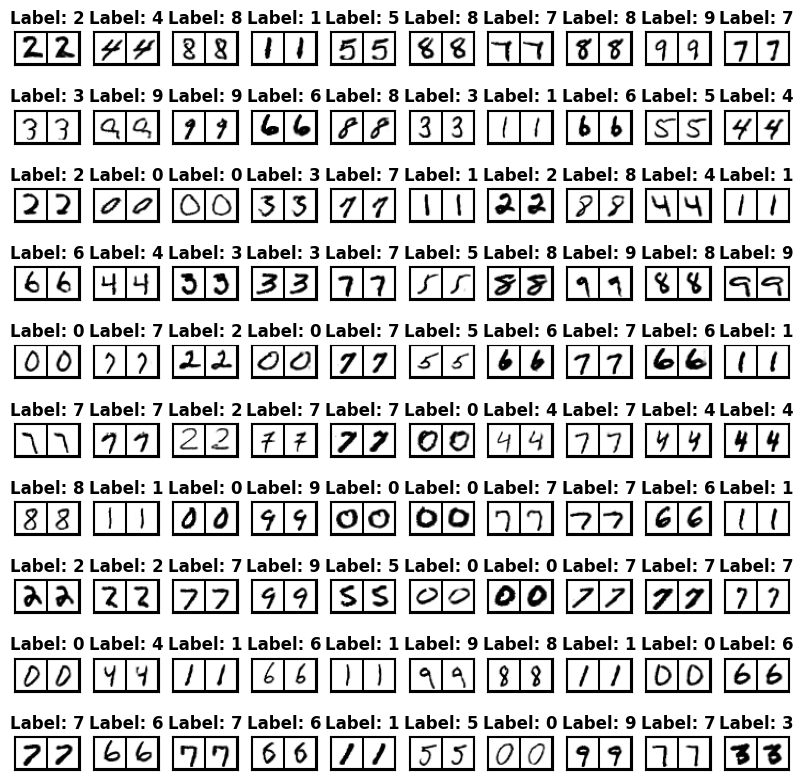

In [21]:
plot_reconstructions(test_images, test_reconstructions, test_labels, nrows=10, ncols=10)
plt.show()

The reconstructions seem to be of much higher quality than the reconstructions from the simple VAE that we trained. This is not completely surprising though given the high complexity of the NVAE model.

Again we also analyze the average squared reconstruction error
\begin{equation*}
    \mathrm{sqerr} := \frac{1}{10000} \sum_{i=1}^{10000} \|\mathbf{x}_i - \tilde{\mathbf{x}}_i\|^2_2
\end{equation*}
of the images $\mathbf{x}_i \in {[0,1]}^{784}$ and their reconstructions $\tilde{\mathbf{x}}_i \in \mathbb{R}^{784}$ ($i = 1,\ldots, 10000$) in the MNIST test data set as an objective measure for the quality of the reconstructions. To reduce the computation time, in particular when you do not use a GPU, we estimate it only from 10 batches of 10 random test images and do not evaluate the full test data set. If the estimation is reasonably fast you can increase the number of batches.

In [22]:
# only analyze 10 out of 1000 batches
# you can increase this if you use a GPU
nbatches = 100

sqerrors = []

with torch.no_grad(): # no gradients required
    for i, (images, _) in enumerate(testdata):
        # only analyze nbatches batches
        if i >= nbatches:
            break

        # show progress
        print("processing batch {:3d} ...".format(i + 1))
        
        # move data to GPU if available
        images = images.to(device)
    
        # compute reconstructions
        logits = model(preprocess(images))[0]
        reconstructions = centercrop(model.decoder_output(logits).mean)
        
        # compute average squared reconstruction error
        sqerror = (images - reconstructions).pow(2).view(-1, 784).sum(dim=1).mean()
        sqerrors.append(sqerror)

sqerr = torch.tensor(sqerrors).mean()
print(f"Average squared reconstruction error: {sqerr}")

processing batch   1 ...
processing batch   2 ...
processing batch   3 ...
processing batch   4 ...
processing batch   5 ...
processing batch   6 ...
processing batch   7 ...
processing batch   8 ...
processing batch   9 ...
processing batch  10 ...
processing batch  11 ...
processing batch  12 ...
processing batch  13 ...
processing batch  14 ...
processing batch  15 ...
processing batch  16 ...
processing batch  17 ...
processing batch  18 ...
processing batch  19 ...
processing batch  20 ...
processing batch  21 ...
processing batch  22 ...
processing batch  23 ...
processing batch  24 ...
processing batch  25 ...
processing batch  26 ...
processing batch  27 ...
processing batch  28 ...
processing batch  29 ...
processing batch  30 ...
processing batch  31 ...
processing batch  32 ...
processing batch  33 ...
processing batch  34 ...
processing batch  35 ...
processing batch  36 ...
processing batch  37 ...
processing batch  38 ...
processing batch  39 ...
processing batch  40 ...


## Generating images

Of course, we can also generate new images from the NVAE. Here we sample one image from the NVAE with temperature `T` and display it.

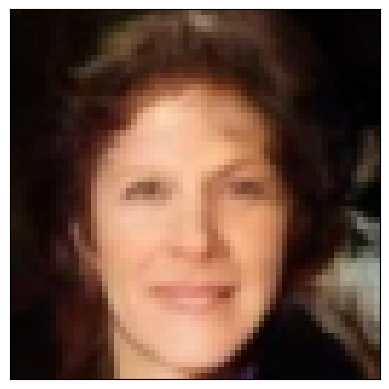

In [212]:
# sample a single image with temperature `T`
T = .9

with torch.no_grad(): # no gradients required
    # compute decoding distribution
    logits = model.sample(1, T) 
    output = model.decoder_output(logits)
    
    # use non-binarized sample for MNIST, otherwise sample from the decoding distribution
    output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) else output.sample()
    
    # reorder the axes as (nsamples, channels, height, width)
    output_img = output_img.permute(0, 2, 3, 1).squeeze().cpu().numpy()

    # crop MNIST images
    if model.dataset == 'mnist':
        output_img = output_img[2:30, 2:30]

# plot sample
plt.xticks([])
plt.yticks([])
if model.dataset == 'mnist':
    # plot MNIST images as grayscale images
    plt.imshow(output_img, vmin=0.0, vmax=1.0, cmap='gray_r')
else:
    plt.imshow(output_img)
plt.show()

### Task

Play around with the notebook. Some suggestions:
- Change the temperature and study how it affects the quality of the generated image.  
When looking at the extreme T = 0.01 we only see 3 or sometimes 5  
Lower T reduces the diversity of the image set  
Above 1 we get unrecognizable images
- Generate images from pretrained NVAEs for other image data sets (you can not analyze the reconstructions since we did not load these other data sets).

**Warning: The files with pretrained parameters for other data sets are large (> 1.5GB). You might have to delete some files with pretrained parameters in the file browser on Google Colab to free up space. Since the NVAEs for other image data sets are also more complex (e.g., more convolutional layers) it takes more time to run them, in particular if you do not use a GPU.**

In [129]:
# load pretrained NVAE
# possible data sets:
# "mnist", "celeba_64", "celeba_256a", "celeba_256b", "cifar10a", "cifar10b", "ffhq"
model = nvae.load_pretrained_model("celeba_64", use_gdown=True)

# move model to the GPU if available
model = model.to(device)

downloading checkpoint of pretrained model for celeba_64 ...


Downloading...
From (original): https://drive.google.com/uc?id=1IKAzjnq-2mN36xl1XEIaTrqxEHo7PM4b
From (redirected): https://drive.google.com/uc?id=1IKAzjnq-2mN36xl1XEIaTrqxEHo7PM4b&confirm=t&uuid=323f25f8-a94f-4741-8d26-3293ad850648
To: c:\Users\caleb\OneDrive - Uppsala universitet\Fall 2025\APML\Exercise Sessions\APML_exercise_sessions\Lab\checkpoint_celeba_64.pt
100%|██████████| 1.84G/1.84G [03:56<00:00, 7.80MB/s]


len log norm: 730
len bn: 436


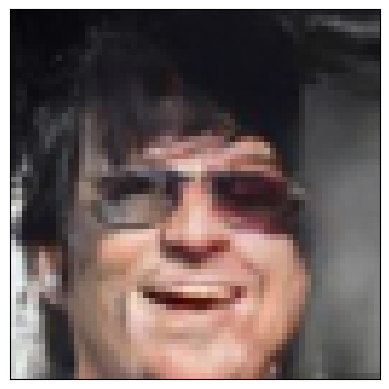

In [186]:
# sample a single image with temperature `T`
T = 1

with torch.no_grad(): # no gradients required
    # compute decoding distribution
    logits = model.sample(1, T) 
    output = model.decoder_output(logits)
    
    # use non-binarized sample for MNIST, otherwise sample from the decoding distribution
    output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) else output.sample()
    
    # reorder the axes as (nsamples, channels, height, width)
    output_img = output_img.permute(0, 2, 3, 1).squeeze().cpu().numpy()

    # crop MNIST images
    if model.dataset == 'mnist':
        output_img = output_img[2:30, 2:30]

# plot sample
plt.xticks([])
plt.yticks([])
if model.dataset == 'mnist':
    # plot MNIST images as grayscale images
    plt.imshow(output_img, vmin=0.0, vmax=1.0, cmap='gray_r')
else:
    plt.imshow(output_img)
plt.show()